<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-information-from-GFF-file" data-toc-modified-id="Get-information-from-GFF-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get information from GFF file</a></span><ul class="toc-item"><li><span><a href="#Convert-GFF-to-Pandas-DataFrame" data-toc-modified-id="Convert-GFF-to-Pandas-DataFrame-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Convert GFF to Pandas DataFrame</a></span></li></ul></li><li><span><a href="#KEGG-and-COGs" data-toc-modified-id="KEGG-and-COGs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>KEGG and COGs</a></span><ul class="toc-item"><li><span><a href="#Generate-nucleotide-fasta-files-for-CDS" data-toc-modified-id="Generate-nucleotide-fasta-files-for-CDS-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate nucleotide fasta files for CDS</a></span></li><li><span><a href="#Run-EggNOG-Mapper" data-toc-modified-id="Run-EggNOG-Mapper-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run EggNOG Mapper</a></span></li><li><span><a href="#Get-KEGG-attributes" data-toc-modified-id="Get-KEGG-attributes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get KEGG attributes</a></span></li><li><span><a href="#Save-KEGG-information" data-toc-modified-id="Save-KEGG-information-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Save KEGG information</a></span></li><li><span><a href="#Save-COGs-to-annotation-dataframe" data-toc-modified-id="Save-COGs-to-annotation-dataframe-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save COGs to annotation dataframe</a></span></li></ul></li><li><span><a href="#Uniprot-ID-mapping" data-toc-modified-id="Uniprot-ID-mapping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Uniprot ID mapping</a></span></li><li><span><a href="#Clean-up-and-save-annotation" data-toc-modified-id="Clean-up-and-save-annotation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clean up and save annotation</a></span><ul class="toc-item"><li><span><a href="#Final-statistics" data-toc-modified-id="Final-statistics-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Final statistics</a></span></li><li><span><a href="#Fill-missing-values" data-toc-modified-id="Fill-missing-values-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Fill missing values</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append('..')

In [2]:
from pymodulon.gene_util import *
import os
from Bio import SeqIO

In [3]:
org_dir = '../example_data/example_annotation'
kegg_organism_code = 'sai'
seq_dir = os.path.join(org_dir,'sequence_files')

# Get information from GFF file

## Convert GFF to Pandas DataFrame

In [4]:
annot_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.gff3'):
        gff = os.path.join(seq_dir,filename)
        annot_list.append(gff2pandas(gff))
keep_cols = ['refseq','start','end','strand','gene_name','locus_tag','old_locus_tag','gene_product','ncbi_protein']
DF_annot = pd.concat(annot_list)[keep_cols]
DF_annot = DF_annot.drop_duplicates('locus_tag')
DF_annot.set_index('locus_tag',drop=True,inplace=True)

In [5]:
tpm_file = os.path.join(org_dir,'data','log_tpm.csv')
DF_log_tpm = pd.read_csv(tpm_file,index_col=0)

Check that the genes are the same in the expression dataset as in the annotation dataframe.

In [6]:
# Mismatched genes are listed below
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


# KEGG and COGs

## Generate nucleotide fasta files for CDS

In [7]:
cds_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.fasta'):
        fasta = os.path.join(seq_dir,filename)
        seq = SeqIO.read(fasta,'fasta')
        
        # Get gene information for genes in this fasta file
        df_genes = DF_annot[DF_annot.refseq == seq.id]
        for i,row in df_genes.iterrows():
            cds = seq[row.start-1:row.end]
            if row.strand == '-':
                cds = seq[row.start-1:row.end].reverse_complement()
            cds.id = row.name
            cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
            cds_list.append(cds)

In [8]:
SeqIO.write(cds_list,os.path.join(seq_dir,'CDS.fna'),'fasta')

2296

## Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file to `<org_dir>/data/eggNOG.annotations`

## Get KEGG attributes

In [9]:
DF_eggnog = pd.read_csv(os.path.join(org_dir,'data','eggNOG.annotations'),sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

In [10]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['locus_tag','database','kegg_id'])

DF_kegg.head()

,locus_tag,database,kegg_id
0,SACI_RS00005,KEGG_orth,ko:K10725
1,SACI_RS00040,KEGG_orth,ko:K01916
2,SACI_RS00060,KEGG_orth,ko:K01515
3,SACI_RS00070,KEGG_orth,ko:K01151
4,SACI_RS00085,KEGG_orth,ko:K01560


## Save KEGG information

In [29]:
DF_annot.to_csv(os.path.join(org_dir,'data','kegg_mapping.csv'))

## Save COGs to annotation dataframe

In [11]:
DF_annot['COG'] = DF_eggnog.COG

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

# Uniprot ID mapping

In [12]:
# Try the uniprot ID mapping tool - Use EMBL for Genbank file and P_REFSEQ_AC for Refseq file
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='P_REFSEQ_AC',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')

# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
assert(len(DF_annot) == len(DF_annot))

In [13]:
DF_annot.head()

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
SACI_RS00005,NC_007181.1,101,1261,+,None,Saci_0001,AAA family ATPase,WP_011276932.1,L,A0A0U3H3T6
SACI_RS00010,NC_007181.1,1294,1629,+,None,Saci_0002,hypothetical protein,WP_011276933.1,NaN,A0A0U3FP71
SACI_RS00015,NC_007181.1,1665,2504,+,None,Saci_0003,hypothetical protein,WP_011276934.1,S,A0A0U2NAH6
SACI_RS00020,NC_007181.1,2553,3056,-,None,Saci_0004,hypothetical protein,WP_015385334.1,NaN,A0A0U3HCE5
SACI_RS00025,NC_007181.1,3049,3768,-,None,Saci_0005,hypothetical protein,WP_011276936.1,NaN,Q4JCP4


# Clean up and save annotation

In [14]:
# Temporarily remove warning
pd.set_option('mode.chained_assignment', None)

In [19]:
# Reorder annotation file
order = ['gene_name','start','end','strand','gene_product','COG','uniprot']
DF_annot = DF_annot[order]

In [20]:
DF_annot.head()

,gene_name,start,end,strand,gene_product,COG,uniprot
locus_tag,,,,,,,
SACI_RS00005,None,101,1261,+,AAA family ATPase,L,A0A0U3H3T6
SACI_RS00010,None,1294,1629,+,hypothetical protein,NaN,A0A0U3FP71
SACI_RS00015,None,1665,2504,+,hypothetical protein,S,A0A0U2NAH6
SACI_RS00020,None,2553,3056,-,hypothetical protein,NaN,A0A0U3HCE5
SACI_RS00025,None,3049,3768,-,hypothetical protein,NaN,Q4JCP4


## Final statistics

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
sns.set_style('ticks')

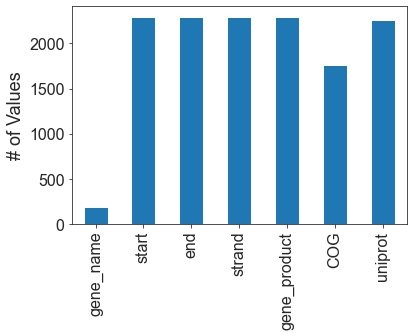

In [25]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

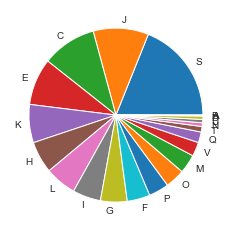

In [26]:
counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

## Fill missing values

In [27]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

In [28]:
DF_annot.to_csv(os.path.join(org_dir,'data','gene_info.csv'))